In [912]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV

from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

# Load the data

In [796]:
print(f"[INFO] Current working directory: {os.getcwd()}")

[INFO] Current working directory: c:\Users\Studen\Documents\vscode_projects\kaggleCompetitions\Titanic


### Train data

In [797]:
train_data_path = Path('titanic_dataset/train.csv')

In [798]:
train_df = pd.read_csv(train_data_path, index_col='PassengerId')
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [799]:
women = train_df.loc[train_df.Sex == 'female']['Survived']
rate_women = sum(women)/len(women)
print(f"[INFO] Percentage of women who survived: {rate_women:.4%}")

[INFO] Percentage of women who survived: 74.2038%


In [800]:
men = train_df.loc[train_df.Sex == 'male']['Survived']
rate_men = sum(men)/len(men)
print(f"[INFO] Percentage of men who survived: {rate_men:.4%}")

[INFO] Percentage of men who survived: 18.8908%


### Test data

In [801]:
test_data_path = Path('titanic_dataset/test.csv')

In [802]:
test_df = pd.read_csv(test_data_path, index_col='PassengerId')
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# EDA - Exploratory Data Analysis

## <h3 style="color:orange;">Features</h3>

- **PassengerId** - Passenger ID - <p1 style="color:blue;">Number</p1>
- **Survived** - Survived - <p1 style="color:blue;">Bool</p1>
- **Pclass** - Ticket class - available 1 = 1st, 2 = 2nd, 3 = 3rd - <p1 style="color:blue;">Number</p1>
- **Name** - First name, Last Name and optional Title - <p1 style="color:red;">String</p1>
- **Sex** - Sex of passenger - available: male and female - <p1 style="color:red;">String</p1>
- **Age** - Age in years - <p1 style="color:blue;">Number</p1>
- **SibSp** - of siblings / spouses aboard the Titanic - <p1 style="color:blue;">Number</p1>
- **Parch** - of parents / children aboard the Titanic - <p1 style="color:blue;">Number</p1>
- **Ticket** - Ticket Id - <p1 style="color:red;">String
- **Fare** - Passenger fare / Ticker price - <p1 style="color:blue;">Number</p1>
- **Cabin** - Cabin number - <p1 style="color:red;">String</p1>
- **Embarked** - Port of Embarkation - available C = Cherbourg, Q = Queenstown, S = Southampton - <p1 style="color:red;">String</p1>

<p1 style="color:blue;">Blue color</p1> = Numerical columns <br>
<p1 style="color:red;">Blue color</p1> = Categorical columns

In [803]:
rows_in_train_data = train_df.shape[0]
rows_in_test_data = test_df.shape[0]

print(f"[INFO] Rows in train data: {rows_in_train_data}")
print(f"[INFO] Rows in test data: {rows_in_test_data}")
print(f"[INFO] Total data: {rows_in_train_data + rows_in_test_data}")

[INFO] Rows in train data: 891
[INFO] Rows in test data: 418
[INFO] Total data: 1309


Null columns in train data

In [804]:
null_columns = train_df.columns[train_df.isnull().any()]
print(train_df[null_columns].isnull().sum())

Age         177
Cabin       687
Embarked      2
dtype: int64


Null columns in test data

In [805]:
null_columns = test_df.columns[test_df.isnull().any()]
print(test_df[null_columns].isnull().sum())

Age       86
Fare       1
Cabin    327
dtype: int64


In [806]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [807]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Check correlations between data

<AxesSubplot: title={'center': 'Correlations between data'}>

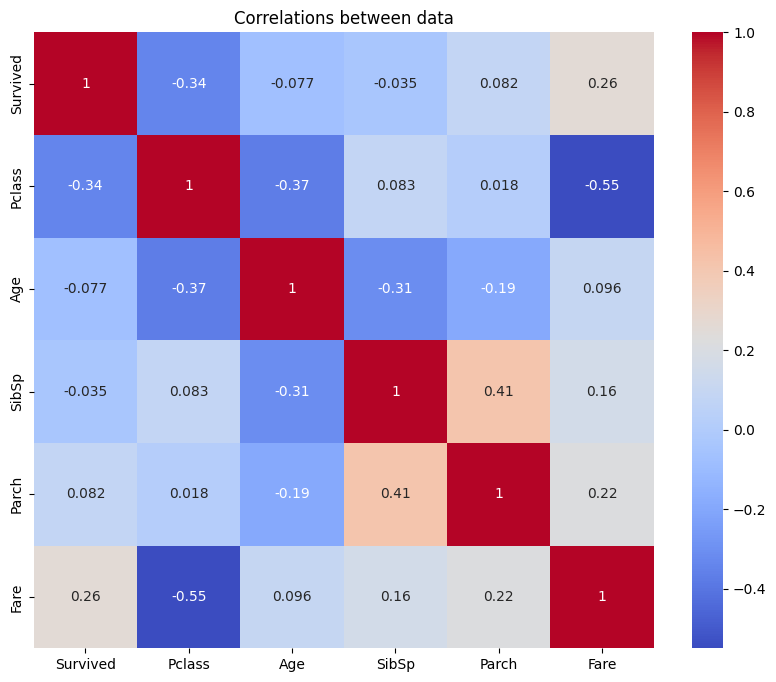

In [808]:
plt.figure(figsize=(10, 8))
plt.title("Correlations between data")

sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap='coolwarm')


### Impact of sex on survival

In [809]:
sex_impact_on_survival = train_df[['Sex', 'Survived']].groupby('Sex')['Survived'].mean()
print(f"[INFO] Survived:\n{sex_impact_on_survival}")

[INFO] Survived:
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


Text(0.5, 1.0, 'Correlations between sex and survival')

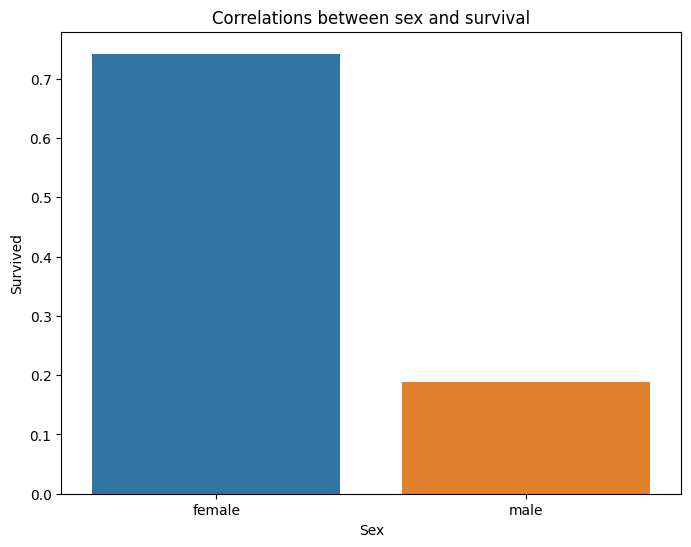

In [810]:
plt.figure(figsize=(8,6))
sns.barplot(x='Sex', y='Survived', data=sex_impact_on_survival.reset_index())
plt.title('Correlations between sex and survival')

### Impact of ticket class on survival

In [811]:
pclass_impact_on_survival = train_df[['Pclass', 'Survived']].groupby('Pclass')['Survived'].mean()
print(f"[INFO] Survived:\n{pclass_impact_on_survival}")

[INFO] Survived:
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


Text(0.5, 1.0, 'Correlations between ticket class and survival')

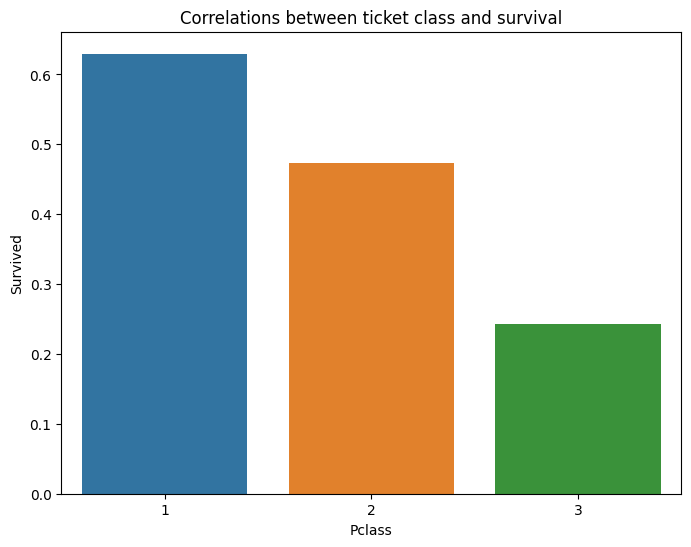

In [812]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Pclass', y='Survived', data=pclass_impact_on_survival.reset_index())
plt.title("Correlations between ticket class and survival")

### Categorical and Numerical columns

In [813]:
categorical_cols = [cname for cname in train_df.columns if train_df[cname].dtype == "object"]
numerical_cols = [cname for cname in train_df.columns if train_df[cname].dtype in ["int64", "float64"]]

print(f"[INFO] We have {len(categorical_cols)} categorical columns: {categorical_cols}")
print(f"[INFO] We have {len(numerical_cols)} numerical columns: {numerical_cols}")

[INFO] We have 5 categorical columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
[INFO] We have 6 numerical columns: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


# Data preparation

Merging train and test sets during cleaning data period. <br>
We will separate them before training and evaluation.

In [814]:
data_df = pd.concat([train_df, test_df])
print(f"[INFO] Number of examples in train set: {rows_in_train_data}")
print(f"[INFO] Number of examples in test set: {rows_in_test_data}")
print(f"[INFO] Number of examples in merged set: {data_df.shape[0]}")

[INFO] Number of examples in train set: 891
[INFO] Number of examples in test set: 418
[INFO] Number of examples in merged set: 1309


## Handle columns with null

In [815]:
cols_with_missing = [col for col in data_df.columns if data_df[col].isnull().any() or data_df[col].isna().any()]
cols_with_missing

['Survived', 'Age', 'Fare', 'Cabin', 'Embarked']

Use meadian for numeric rather than mean, because the median only uses one or two values, it's unaffected by extreme outliers or non-symmetric distributions of scores. <br>
Mode gives you most occuring value.

In [816]:
data_df['Age'].fillna(data_df['Age'].median(), inplace=True)

data_df['Embarked'].fillna(data_df['Embarked'].mode()[0], inplace=True)

data_df['Fare'].fillna(data_df['Fare'].median(), inplace=True)

## Feature Engineering

### Extract lastname from name

In [817]:
data_df['LastName'] = data_df['Name'].apply(lambda name: name.split(',')[0].strip())
data_df['LastName'].value_counts()

Andersson    11
Sage         11
Goodwin       8
Asplund       8
Davies        7
             ..
Milling       1
Maisner       1
Goncalves     1
Campbell      1
Saether       1
Name: LastName, Length: 875, dtype: int64

### Extract title from name
Extract title from name and replace rare titles.

In [818]:
data_df['Title'] = data_df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
data_df['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [819]:
mapping = {
    'Col': 'Mr', 
    'Mlle': 'Miss', 
    'Major': 'Mr', 
    'Ms': 'Miss',
    'Lady': 'Mrs', 
    'Sir': 'Mr',
    'Mme': 'Miss',
    'Don': 'Mr', 
    'Capt': 'Mr', 
    'the Countess': 'Mrs', 
    'Jonkheer': 'Mr',
    'Dona': 'Mrs'
}

data_df.replace({'Title' : mapping}, inplace=True)

data_df['Title'].value_counts()

Mr        767
Miss      265
Mrs       200
Master     61
Rev         8
Dr          8
Name: Title, dtype: int64

In [820]:
title_impact_on_survival = data_df[~data_df['Survived'].isna()][['Title', 'Survived']].groupby('Title')['Survived'].mean()
print(f"[INFO] Survived:\n{title_impact_on_survival}")

[INFO] Survived:
Title
Dr        0.428571
Master    0.575000
Miss      0.704301
Mr        0.160000
Mrs       0.795276
Rev       0.000000
Name: Survived, dtype: float64


Text(0.5, 1.0, 'Correlations between Title class and survival')

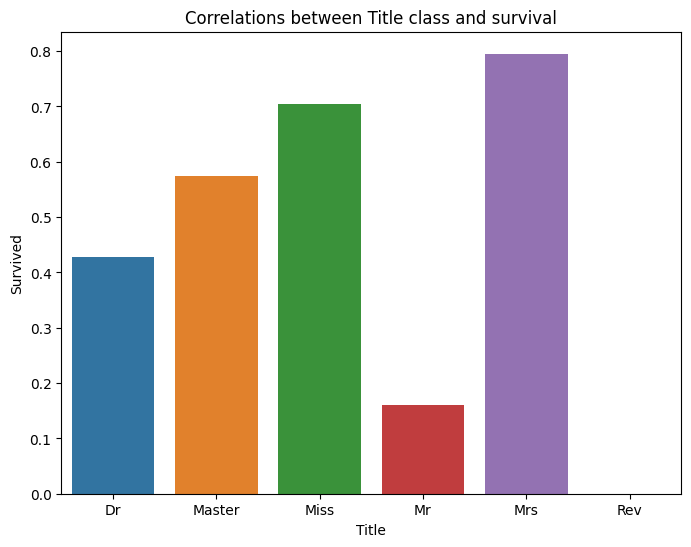

In [821]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Title', y='Survived', data=title_impact_on_survival.reset_index())
plt.title("Correlations between Title class and survival")

### Family size
Merge SibSp (siblings / spouses aboard) and Parch (parents / children aboard) into FamilySize and add one (current passenger). 

In [822]:
data_df['FamilySize'] = data_df['SibSp'] + data_df['Parch'] + 1
data_df['FamilySize'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: FamilySize, dtype: int64

In [823]:
familySize_impact_on_survival = data_df[['FamilySize', 'Survived']].groupby('FamilySize')['Survived'].mean()
print(f"[INFO] Survived:\n{familySize_impact_on_survival}")

[INFO] Survived:
FamilySize
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64


Text(0.5, 1.0, 'Correlations between FamilySize class and survival')

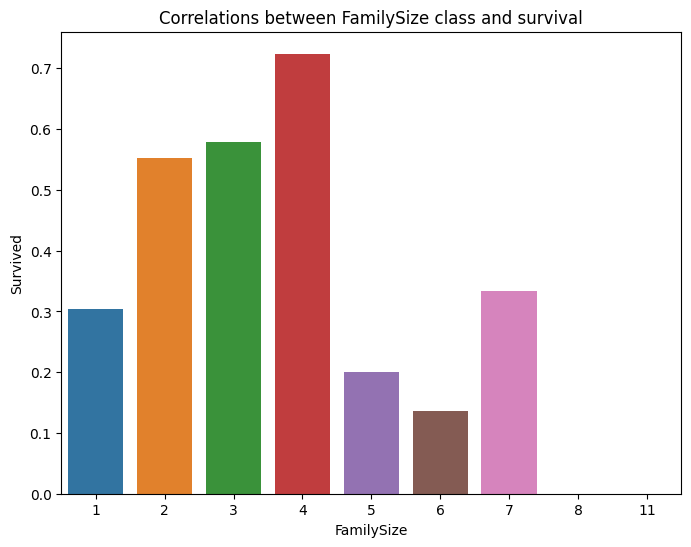

In [824]:
plt.figure(figsize=(8, 6))
sns.barplot(x='FamilySize', y='Survived', data=familySize_impact_on_survival.reset_index())
plt.title("Correlations between FamilySize class and survival")

### Group Family size into 5 categories

In [825]:
data_df['FamilySizeBin'] = pd.cut(data_df['FamilySize'], bins=5, duplicates='drop', include_lowest=True, labels=[1, 2, 3, 4, 5])

### Group Age into 5 categories

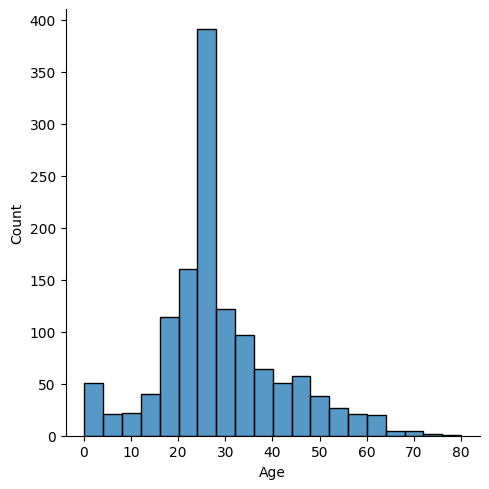

In [826]:
sns.displot(data_df['Age'], bins=20, kde=False)

In [827]:
data_df['AgeBin'] = pd.cut(data_df['Age'], bins=5, duplicates='drop', include_lowest=True, labels=[1, 2, 3, 4, 5])

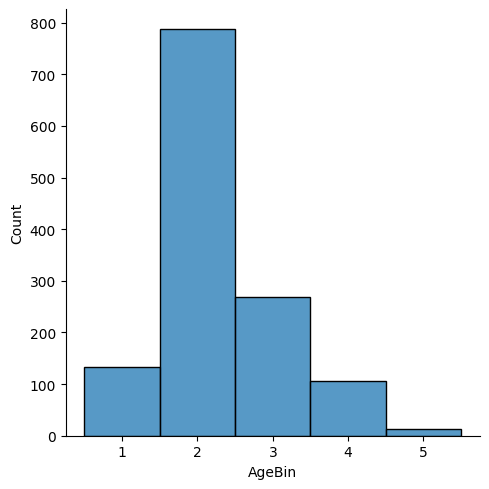

In [828]:
sns.displot(data_df['AgeBin'], bins=5, kde=False)

### Group Fare into 5 categories

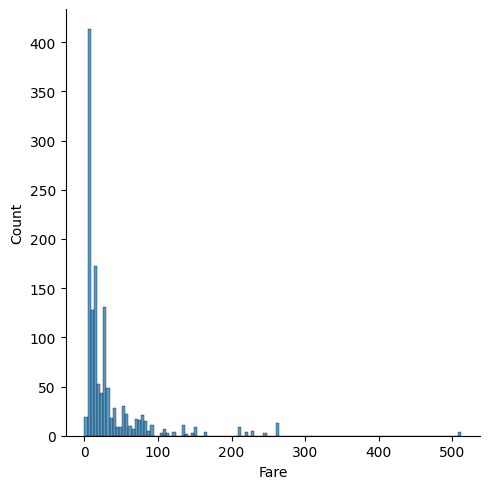

In [829]:
sns.displot(data_df['Fare'])

In [830]:
data_df['FareBin'] = pd.cut(data_df['Fare'], bins=5, labels=[1, 2, 3, 4, 5])

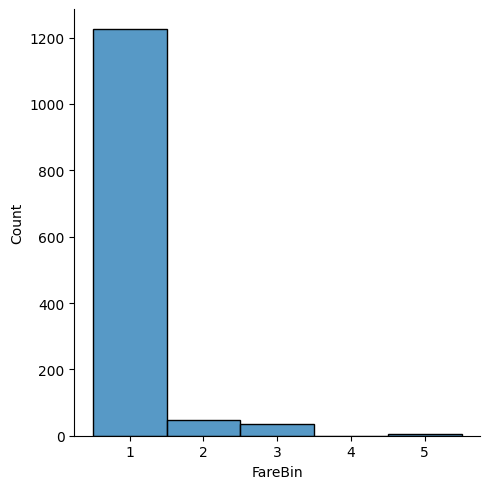

In [831]:
sns.displot(data_df['FareBin'], bins=5, kde=False)

### Add HasCabin feature

In [832]:
data_df['HasCabin'] = data_df['Cabin'].fillna(0) != 0
data_df['HasCabin'] = data_df['HasCabin'].astype(int)
data_df['HasCabin']

PassengerId
1       0
2       1
3       0
4       1
5       0
       ..
1305    0
1306    1
1307    0
1308    0
1309    0
Name: HasCabin, Length: 1309, dtype: int32

In [833]:
hasCabin_impact_on_survival = data_df[['HasCabin', 'Survived']].groupby('HasCabin').mean()#  ['Survived'].mean()
print(f"[INFO] Survived:\n{hasCabin_impact_on_survival.head()}")

# hasCabin_impact_on_survival = data_df[['HasCabin', 'Survived']].groupby('HasCabin')['Survived'].mean()
# print(f"[INFO] Survived:\n{hasCabin_impact_on_survival.head()}")

[INFO] Survived:
          Survived
HasCabin          
0         0.299854
1         0.666667


Text(0.5, 1.0, 'Correlations between HasCabin class and survival')

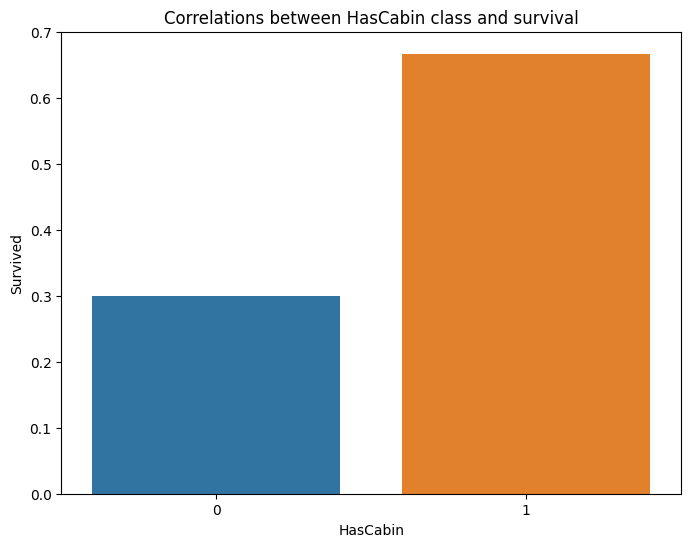

In [834]:
plt.figure(figsize=(8, 6))
sns.barplot(x='HasCabin', y='Survived', data=hasCabin_impact_on_survival.reset_index())
plt.title("Correlations between HasCabin class and survival")

### Handle categorical columns

In [835]:
label = LabelEncoder()

data_df['SexCode'] = label.fit_transform(data_df['Sex'])

data_df['EmbarkedCode'] = label.fit_transform(data_df['Embarked'])

data_df['TitleCode'] = label.fit_transform(data_df['Title'])

data_df.sample(10, random_state=10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Title,FamilySize,FamilySizeBin,AgeBin,FareBin,HasCabin,SexCode,EmbarkedCode,TitleCode
PassengerId,,,,,,,,,,,,,,,,,,,,,
272,1.0,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S,Tornquist,Mr,1,1,2,1,0,1,2,3
376,1.0,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,28.0,1,0,PC 17604,82.1708,NaN,C,Meyer,Mrs,2,1,2,1,0,0,0,4
1244,NaN,2,"Dibden, Mr. William",male,18.0,0,0,S.O.C. 14879,73.5000,NaN,S,Dibden,Mr,1,1,2,1,0,1,2,3
146,0.0,2,"Nicholls, Mr. Joseph Charles",male,19.0,1,1,C.A. 33112,36.7500,NaN,S,Nicholls,Mr,3,1,2,1,0,1,2,3
1274,NaN,3,"Risien, Mrs. Samuel (Emma)",female,28.0,0,0,364498,14.5000,NaN,S,Risien,Mrs,1,1,2,1,0,0,2,4
1194,NaN,2,"Phillips, Mr. Escott Robert",male,43.0,0,1,S.O./P.P. 2,21.0000,NaN,S,Phillips,Mr,2,1,3,1,0,1,2,3
1168,NaN,2,"Parker, Mr. Clifford Richard",male,28.0,0,0,SC 14888,10.5000,NaN,S,Parker,Mr,1,1,2,1,0,1,2,3
342,1.0,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S,Fortune,Miss,6,3,2,3,1,0,2,2
599,0.0,3,"Boulos, Mr. Hanna",male,28.0,0,0,2664,7.2250,NaN,C,Boulos,Mr,1,1,2,1,0,1,0,3


### Scale data

In [836]:
print("[INFO] Data before scaling:\n")
data_df.head()

[INFO] Data before scaling:



,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Title,FamilySize,FamilySizeBin,AgeBin,FareBin,HasCabin,SexCode,EmbarkedCode,TitleCode
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,2,1,2,1,0,1,2,3
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,2,1,3,1,1,0,0,4
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,1,1,2,1,0,0,2,2
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,2,1,3,1,1,0,2,4
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,1,1,3,1,0,1,2,3


In [837]:
scale = StandardScaler()
col_names = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'FamilySizeBin', 
             'AgeBin', 'FareBin', 'HasCabin', 'SexCode', 'EmbarkedCode', 'TitleCode']
# col_names = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']

data_df[col_names] = scale.fit_transform(data_df[col_names])

print("[INFO] Data after scaling:\n")
data_df.head()

[INFO] Data after scaling:



,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Title,FamilySize,FamilySizeBin,AgeBin,FareBin,HasCabin,SexCode,EmbarkedCode,TitleCode
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.841916,"Braund, Mr. Owen Harris",male,-0.581628,0.481288,-0.445,A/5 21171,-0.503291,NaN,S,Braund,Mr,0.073352,-0.282756,-0.370282,-0.235349,-0.539377,0.743497,0.622279,0.192495
2,1.0,-1.546098,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.658652,0.481288,-0.445,PC 17599,0.734744,C85,C,Cumings,Mrs,0.073352,-0.282756,0.885415,-0.235349,1.853992,-1.344995,-1.834926,1.484682
3,1.0,0.841916,"Heikkinen, Miss. Laina",female,-0.271558,-0.479087,-0.445,STON/O2. 3101282,-0.490240,NaN,S,Heikkinen,Miss,-0.558346,-0.282756,-0.370282,-0.235349,-0.539377,-1.344995,0.622279,-1.099692
4,1.0,-1.546098,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.426099,0.481288,-0.445,113803,0.383183,C123,S,Futrelle,Mrs,0.073352,-0.282756,0.885415,-0.235349,1.853992,-1.344995,0.622279,1.484682
5,0.0,0.841916,"Allen, Mr. William Henry",male,0.426099,-0.479087,-0.445,373450,-0.487824,NaN,S,Allen,Mr,-0.558346,-0.282756,0.885415,-0.235349,-0.539377,0.743497,0.622279,0.192495


## Separate train and test data, and save datasets

In [838]:
X_train = data_df[:rows_in_train_data].copy()
assert X_train.shape[0] == rows_in_train_data, "Number of rows in train dataset don't match"
X_test = data_df[rows_in_train_data:].copy()
assert X_test.shape[0] == rows_in_test_data, "Number of rows in test dataset don't match"

out_path = Path('titanic_dataset/')
X_train.to_csv(out_path / 'train_prepared.csv')
X_test.to_csv(out_path / 'test_prepared.csv')
print(f'[INFO] Datasets saved to: {out_path}')

[INFO] Datasets saved to: titanic_dataset


## Choose the features

In [839]:
y_train = X_train.Survived.astype(int)

In [840]:
features = ['HasCabin', 'Pclass', 'SexCode', 'EmbarkedCode', 'TitleCode', 'FareBin', 'Fare', 'AgeBin', 'Age', 'FamilySizeBin', 'FamilySize']
X_train = X_train[features]
X_test = X_test[features]

X_train.tail()

,HasCabin,Pclass,SexCode,EmbarkedCode,TitleCode,FareBin,Fare,AgeBin,Age,FamilySizeBin,FamilySize
PassengerId,,,,,,,,,,,
887,-0.539377,-0.352091,0.743497,0.622279,2.776869,-0.235349,-0.392119,-0.370282,-0.194041,-0.282756,-0.558346
888,1.853992,-1.546098,-1.344995,0.622279,-1.099692,-0.235349,-0.063437,-0.370282,-0.814181,-0.282756,-0.558346
889,-0.539377,0.841916,-1.344995,0.622279,-1.099692,-0.235349,-0.190076,-0.370282,-0.116523,1.438766,1.336749
890,1.853992,-1.546098,0.743497,-1.834926,0.192495,-0.235349,-0.063437,-0.370282,-0.271558,-0.282756,-0.558346
891,-0.539377,0.841916,0.743497,-0.606323,0.192495,-0.235349,-0.493624,-0.370282,0.193547,-0.282756,-0.558346


## Mutual Information
Locate features with the highest potential.

In [841]:
discrete_features = X_train.dtypes == int

mi_scores = mutual_info_classif(X_train, y_train, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

TitleCode        0.190084
SexCode          0.137487
Fare             0.132255
FamilySize       0.070218
Pclass           0.066945
HasCabin         0.036503
Age              0.009483
FamilySizeBin    0.006178
EmbarkedCode     0.003789
FareBin          0.000000
AgeBin           0.000000
Name: MI Scores, dtype: float64

In [842]:
discrete_features = X_train.dtypes == int

mi_scores = mutual_info_classif(X_train, y_train, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

TitleCode        0.175749
SexCode          0.168614
Fare             0.135344
HasCabin         0.081573
FamilySize       0.051873
Pclass           0.034352
Age              0.027289
EmbarkedCode     0.014054
AgeBin           0.000052
FareBin          0.000000
FamilySizeBin    0.000000
Name: MI Scores, dtype: float64

#### Choosing the features

In [843]:
features = ['HasCabin', 'Pclass', 'SexCode', 'EmbarkedCode', 'TitleCode', 'Fare', 'Age', 'FamilySize']

In [844]:
# features = [mi_scores.index[idx] for idx, element in enumerate(mi_scores.array) if element > 0]
# features

In [845]:
X_train = X_train[features]
X_test = X_test[features]

### Check correlations between data

Text(0.5, 1.0, 'Correlations between data')

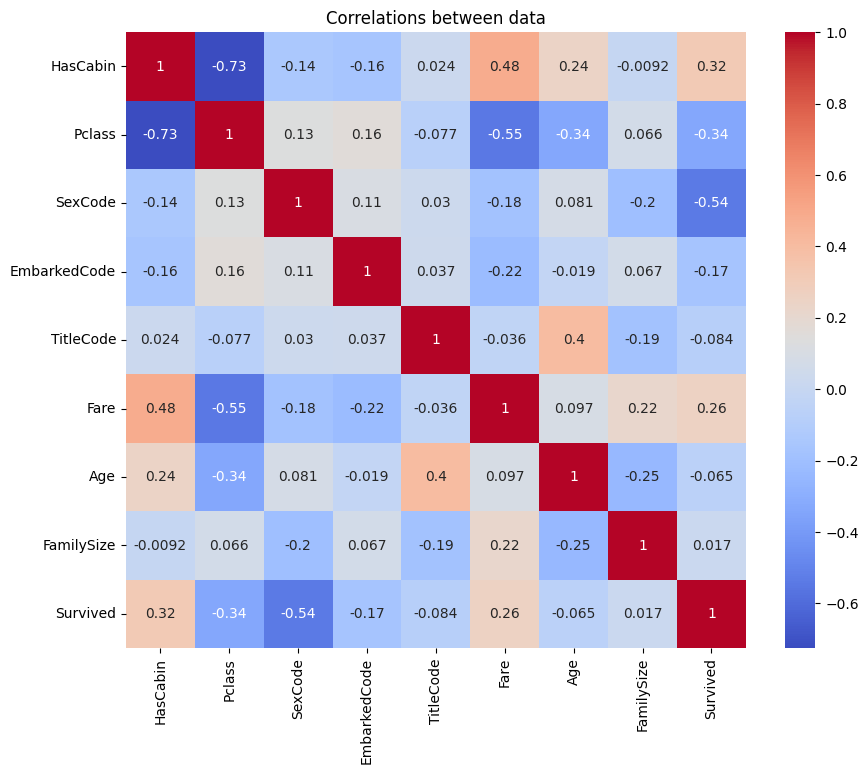

In [846]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.join(y_train).corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlations between data')

# Prediction

## Model building

### Split the train data to train and test sets

In [847]:
print(f"[INFO] Initial shape of train data: {X_train.shape}, {y_train.shape}")

[INFO] Initial shape of train data: (891, 8), (891,)


In [643]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print(f"[INFO] Shape of train data: {X_train_split.shape}, {y_train_split.shape}")
print(f"[INFO] Shape of test data: {X_test_split.shape}, {y_test_split.shape}")

[INFO] Shape of train data: (712, 11), (712,)
[INFO] Shape of test data: (179, 11), (179,)


### Linear regression

In [848]:
lr = LogisticRegression(random_state=0)

cv = cross_val_score(lr, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.79329609 0.7752809  0.78089888 0.78089888 0.80898876]
0.7878727010231625


### Polynomial Lineal regression

In [849]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_split_poly = poly.fit_transform(X_train)
X_train_split_poly.shape

(891, 44)

In [850]:
scale = StandardScaler()

X_train_split_poly = scale.fit_transform(X_train_split_poly)

print("[INFO] Data after scaling:\n")
X_train_split_poly.shape

[INFO] Data after scaling:



(891, 44)

In [851]:
lr = LogisticRegression(random_state=0)

cv = cross_val_score(lr, X_train_split_poly, y_train, cv=5)
print(cv)
print(cv.mean())

[0.83240223 0.80898876 0.8258427  0.8258427  0.85955056]
0.830525390747599


### Support vector classifier

In [852]:
svc = SVC(random_state=0, probability=True)

cv = cross_val_score(svc, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.84916201 0.80337079 0.82022472 0.79775281 0.87078652]
0.8282593685267716


In [853]:
svc = SVC(random_state=0, probability=True)

cv = cross_val_score(svc, X_train_split_poly, y_train, cv=5)
print(cv)
print(cv.mean())

[0.81564246 0.80898876 0.81460674 0.80337079 0.87078652]
0.8226790534178645


### XGB Classifier

Basic train dataset

In [855]:
xgb = XGBClassifier(random_state=0)
cv = cross_val_score(xgb, X_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.81564246 0.79775281 0.85955056 0.79213483 0.84269663]
0.8215554579122466


Polynomial dataset

In [856]:
xgb = XGBClassifier(random_state=0)
cv = cross_val_score(xgb, X_train_split_poly, y_train, cv=5)
print(cv)
print(cv.mean())

[0.79329609 0.80898876 0.87078652 0.78089888 0.84269663]
0.8193333751804659


Checking best parameters

In [914]:
best_score_temp = 0
for i in tqdm(range(50)):
    param_grid = {
        'n_estimators': [450,500,550],
        'colsample_bytree': [0.6, 0.75,0.8,0.85],
        'max_depth': [None],
        'reg_alpha': [1],
        'reg_lambda': [2, 5, 10],
        'subsample': [0.55, 0.6, .65],
        'learning_rate': [0.05, 0.08, 0.1, 0.3, 0.5, 0.8],
        'gamma':[.5,1,2],
        'min_child_weight':[0.005, 0.01, 0.05],
        'sampling_method': ['uniform']
    }

    xgb = XGBClassifier(random_state=0)
    clf_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, cv=5, n_jobs=-1)
    best_clf_xgb = clf_xgb.fit(X_train, y_train)

    if best_clf_xgb.best_score_ > best_score_temp:
        best_score_temp = best_clf_xgb.best_score_
        # Print the best parameters and score
        print('Best parameters:', best_clf_xgb.best_params_)
        print('Best score:', best_clf_xgb.best_score_)
        best_params = best_clf_xgb.best_params_

print('-'*50)   
print(f"[INFO] Best parametars: {best_params}")
    

  2%|▏         | 1/50 [00:06<05:20,  6.54s/it]

Best parameters: {'subsample': 0.65, 'sampling_method': 'uniform', 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 550, 'min_child_weight': 0.05, 'max_depth': None, 'learning_rate': 0.8, 'gamma': 2, 'colsample_bytree': 0.75}
Best score: 0.8428849413093967


  4%|▍         | 2/50 [00:08<03:17,  4.11s/it]

Best parameters: {'subsample': 0.55, 'sampling_method': 'uniform', 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 0.01, 'max_depth': None, 'learning_rate': 0.5, 'gamma': 1, 'colsample_bytree': 0.85}
Best score: 0.8451195781809051


 14%|█▍        | 7/50 [00:20<01:48,  2.51s/it]

Best parameters: {'subsample': 0.6, 'sampling_method': 'uniform', 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 450, 'min_child_weight': 0.05, 'max_depth': None, 'learning_rate': 0.5, 'gamma': 1, 'colsample_bytree': 0.75}
Best score: 0.8473604921222773


100%|██████████| 50/50 [02:02<00:00,  2.46s/it]

--------------------------------------------------
[INFO] Best parametars: {'subsample': 0.6, 'sampling_method': 'uniform', 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 450, 'min_child_weight': 0.05, 'max_depth': None, 'learning_rate': 0.5, 'gamma': 1, 'colsample_bytree': 0.75}
